In [37]:
import pandas as pd
from google.colab import data_table
import matplotlib as plt
import numpy as np
import nltk
import seaborn as sns
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
data_table.enable_dataframe_formatter()
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('maxent_ne_chunker')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()
# transformers
!pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
# library to display the interactive progress
from tqdm.notebook import tqdm
# importing datase
reviews = "/content/labeled_reviews.csv"
df = pd.read_csv(reviews)
data_table.enable_dataframe_formatter()
df.head(1)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,resource_id,review,rating,label
0,1,I spent about a half an hour reviewing the DNA...,5,Positive


In [3]:
# osservo la media della lunghezza delle review per carattere e i valori max e min
length_of_texts = df["review"].apply(len)
medium_length = length_of_texts.mean()
minimum_lenght = length_of_texts.min()
maximum_lenght = length_of_texts.max()


print("Average length: ", medium_length)
print("Minimum length: ", minimum_lenght)
print("Maximum length: ", maximum_lenght)

Average length:  393.82
Minimum length:  14
Maximum length:  3381


In [4]:
print(df.shape)

(300, 4)


In [6]:
# useless column drop
df = df.drop(columns='resource_id')

In [7]:
# checking new column setup
df.columns

Index(['review', 'rating', 'label'], dtype='object')

In [8]:
df.tail(5)

,review,rating,label
295,I think it is great that you are creating a le...,5,Positive
296,This lesson begins with a good tutorial on how...,5,Positive
297,The material explains the MVC design pattern i...,5,Positive
298,Great StAIR project. You lesson was really ea...,5,Positive
299,YouVersion is a tremendous reference resource ...,5,Positive


# Exploratory Data Analysis

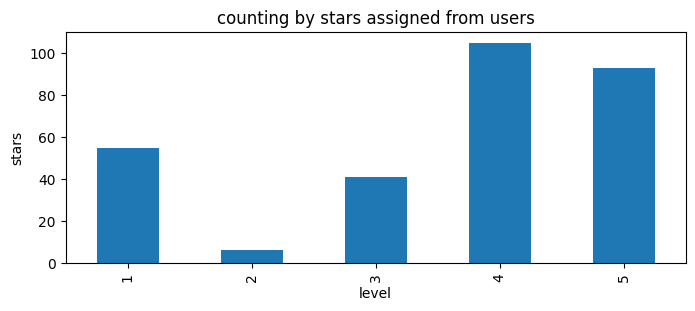

In [9]:
# creation of a plot to check the distribution of reviews according to stars
df["rating"].value_counts().sort_index().plot(kind='bar', title='counting by stars assigned from users', \
                                           xlabel='level', \
                                           ylabel='stars', figsize=(8,3))
plt.show()

In [10]:
# counting rating for stars distribution
df['rating'].value_counts().sort_index()

1     55
2      6
3     41
4    105
5     93
Name: rating, dtype: int64

## Tokenization

In [38]:
# downloading POS tagger to tokenize
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [39]:
# creation of a subset
example = df["review"][0:200].astype(str)
print(example)

0      I spent about a half an hour reviewing the DNA...
1      This is a very useful site for a gen ed biolog...
2      This is a wonderful, informative website!  I s...
3      I was on the site for a total of 20 minutes an...
4      I think that this website offers a great deal ...
                             ...                        
195    While not very interactive, the site had a ton...
196    With IE Explorer (Win98) I could not get apple...
197    Screencast.com is a terrific tool for storing,...
198    Thousands of presentations on any topic are av...
199                   Thnks fo providing this resource. 
Name: review, Length: 200, dtype: object


In [40]:
# reviews' type
print(type(df['review']))

<class 'pandas.core.series.Series'>


In [41]:
# conversion of reviews in strings to tokenize
df['review'] = df['review'].astype(str)

In [ ]:
# tokenization of some reviews
nltk.download('punkt')
reviews = df['review'].head(500).tolist()

# tokenization of ALL reviews
tokenized_reviews = [nltk.word_tokenize(review) for review in reviews]

# print the results
for review in tokenized_reviews:
    print(review[:10])

In [ ]:
# having a look
tokenized_reviews[50]

In [ ]:
# token list lite
flattened_tokens = [token for sublist in tokenized_reviews for token in sublist]

# Calculating the distinct frequency of tokens
frequency_token = FreqDist(flattened_tokens)

frequency_token.most_common(50)

In [43]:
# add column with review copy where I will do the cleaning operations
df["text_copy"] = df["review"].copy()
df["whole_copy"] = df["review"].copy()
df.tail(1)

,resource_id,review,rating,label,text_copy,whole_copy
299,4555,YouVersion is a tremendous reference resource ...,5,Positive,YouVersion is a tremendous reference resource ...,YouVersion is a tremendous reference resource ...


### Stop-words removal

In [44]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

df['text_copy'] = df['text_copy'].apply(remove_stopwords)

In [ ]:
df.head(10)

### Punctuation removal

In [ ]:
import re

def remove_punctuation(text):
 # Using regular expression to remove punctuation
    # all characters that are not alphanumeric or whitespace [^\w\s]
    cleaned_text = re.sub(r'[^\w\s]', ' ', text)
    return cleaned_text

df['text_copy'] = df['text_copy'].apply(remove_punctuation)

# unlike tokenization, this is better for me to do directly on the column

In [ ]:
df.tail(5)

### Lemmatization

In [ ]:
# conversion of the whole column to lower case
df["text_copy"] = df["text_copy"].str.lower()

In [ ]:
# I apply lemmatization, having a not very large dataset

nltk.download('wordnet')

# I apply a function to obtain the POS tag for lemmatisation
# is not mandatory but I make the process more efficient
def get_pos_tag(word):
  #
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# lemmatizer initialisation
lemmatizer = WordNetLemmatizer()

# apply
df["text_copy"] = \
df["text_copy"].apply(lambda x: " ".join([lemmatizer.lemmatize(word, get_pos_tag(word))
    for word in nltk.word_tokenize(x)]))


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df.tail(5)

In [ ]:
df.iloc[50:101]

# VADER

In [19]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [20]:
# instance of the Sentiment Intensity Analyzer class
analyzer = SentimentIntensityAnalyzer()

In [21]:
# analysis of the sentiment of each review and add a column with the sentiment score
scores = df['text_copy'].apply(lambda x: analyzer.polarity_scores(x)).tolist()

In [22]:
vaders = pd.DataFrame(scores)
vaders.rename(columns={'compound':'processed'},inplace=True)
vaders

,neg,neu,pos,processed
0,0.029,0.731,0.239,0.9223
1,0.000,0.633,0.367,0.4404
2,0.000,0.702,0.298,0.9060
3,0.000,0.659,0.341,0.9485
4,0.000,0.744,0.256,0.9817
...,...,...,...,...
295,0.026,0.527,0.447,0.9905
296,0.031,0.671,0.299,0.9756
297,0.000,0.734,0.266,0.4404
298,0.000,0.584,0.416,0.9672


In [23]:
df_punti = df.join(vaders['processed'], rsuffix='_vader')

In [24]:
df.head(1)

,review,rating,label,text_copy,whole_copy
0,I spent about a half an hour reviewing the DNA...,5,Positive,spent half hour reviewing DNA beginnings prese...,I spent about a half an hour reviewing the DNA...


In [25]:
# Analysing the sentiment of whole reviews
scores_whole = df['whole_copy'].apply(lambda x: analyzer.polarity_scores(x)).tolist()

In [26]:
vader_whole = pd.DataFrame(scores_whole)
vader_whole

,neg,neu,pos,compound
0,0.019,0.822,0.159,0.9223
1,0.000,0.738,0.262,0.4927
2,0.000,0.806,0.194,0.9060
3,0.000,0.802,0.198,0.9584
4,0.000,0.822,0.178,0.9823
...,...,...,...,...
295,0.015,0.725,0.260,0.9914
296,0.017,0.815,0.168,0.9778
297,0.000,0.818,0.182,0.4404
298,0.000,0.743,0.257,0.9661


In [27]:
vader_whole.rename(columns={'compound' :'whole'},inplace=True)
vader_whole

,neg,neu,pos,whole
0,0.019,0.822,0.159,0.9223
1,0.000,0.738,0.262,0.4927
2,0.000,0.806,0.194,0.9060
3,0.000,0.802,0.198,0.9584
4,0.000,0.822,0.178,0.9823
...,...,...,...,...
295,0.015,0.725,0.260,0.9914
296,0.017,0.815,0.168,0.9778
297,0.000,0.818,0.182,0.4404
298,0.000,0.743,0.257,0.9661


In [28]:
df = df.join(vader_whole['whole'], rsuffix='_vader')

In [ ]:
# I now have a dataframe in which I can check the performance of VADER on processed and normal text, compared to labels
df.tail(5)

In [ ]:
#df = df.join(vaders['compound'], rsuffix='_vader')
#df = df.join(vaders['compound'], rsuffix='_vader').join(vader_whole['compound'], rsuffix='_whole')


In [ ]:
df.head(10)

In [ ]:
# sentiment classifier
#df['sentiment'] = df['score'].apply(lambda c: 'Positive' if c >= 0.5 else 'Negative')

# allocation of labels based on a threshold
threshold = 0.5
df['pr_sentiment'] = df['processed'].apply(lambda c: 'Positive' if c >= threshold else ('Neutral' if abs(c - 0.5) < 0.1 else 'Negative'))


df.tail(5)


In [ ]:
threshold = 0.5
df['wh_sentiment'] = df['whole'].apply(lambda c: 'Positive' if c >= threshold else ('Neutral' if abs(c - 0.5) < 0.1 else 'Negative'))


df.columns

Index(['index', 'label', 'rating', 'review', 'text_copy', 'whole_copy',
       'processed', 'whole', 'pr_sentiment', 'wh_sentiment'],
      dtype='object')

In [ ]:
df.tail(1)

In [ ]:
# Now count and compare with the results of VADER

# Count the rows where the sentiment of the first column matches that of the other columns
count_match = df[
    (df['label'] == df['pr_sentiment']) &
    (df['label'] == df['wh_sentiment'])
]

# Count the rows where the sentiment in the first column does not match the sentiment in the other columns
count_mismatch = df[
    (df['label'] != df['pr_sentiment']) |
    (df['label'] != df['wh_sentiment'])
]

# print the results
print("Numero di righe con sentiment corrispondenti:", len(count_match))
print("Numero di righe con sentiment diversi:", len(count_mismatch))



Numero di righe con sentiment corrispondenti: 190
Numero di righe con sentiment diversi: 110


In [ ]:
# Count the rows where the sentiment of the first column matches that of the other columns
count_match = df[
    (df['label'] == df['pr_sentiment'])
]
# Count the rows where the sentiment in the first column does not match the sentiment in the other columns
count_mismatch = df[
    (df['label'] != df['pr_sentiment'])
]
print("Numero di righe con sentiment corrispondenti:", len(count_match))
print("Numero di righe con sentiment diversi:", len(count_mismatch))

Numero di righe con sentiment corrispondenti: 197
Numero di righe con sentiment diversi: 103


In [ ]:
# plot VADER results
ax = sns.barplot(data=df,x='rating',y='score')
ax.set_title('Coumpound score delle review')
plt.show()

In [ ]:
# Create an instance of the SentimentIntensityAnalyzer class
analyzer = SentimentIntensityAnalyzer()

# Analyse the sentiment of each review and add a column with the sentiment score
df['scores'] = df['text_copy'].apply(lambda x: analyzer.polarity_scores(x))

# Create a function to assign sentiment based on threshold
def get_sentiment_label(score):
    if score['compound'] >= 0.5:
        return 'positivo'
    else:
        return 'negativo'


In [ ]:
# Apply function to assign sentiment and create a new 'sentiment' column
df['sentiment'] = df['scores'].apply(get_sentiment_label)

# Calculate the total sentiment for each review
df['total_sentiment'] = df['scores'].apply(lambda x: x['compound'])

# Create a bar plot to display sentiment scores
plt.bar(range(len(df)), df['total_sentiment'], tick_label=df.index)
plt.xlabel('Indice della Recensione')
plt.ylabel('Sentimento Totale')
plt.title('Sentimento Totale per ogni Recensione')
plt.show()

# Show the DataFrame with the 'sentiment' column
print(df[['text_copy', 'sentiment']])


In [ ]:
# performance analysis
analyzer.polarity_scores("This is so beautiful")

{'neg': 0.0, 'neu': 0.375, 'pos': 0.625, 'compound': 0.7177}

In [ ]:
analyzer.polarity_scores("The time I spent was trying and reviewing the material from this link. From this, I spent most of my time trying to figure out what to do on the site to try to figure out the problems or issues discussed. Many of the problems I had to read a few times to try to figure out what there was to do and how to solve the problem. I was also interested to see what all the other links were on the problems, as possible steps to help work through the problems. I found the whole thing to be quit difficult. When I am on the internet looking at a web like this, I feel like I am always looking for the fastest way to find the answer to my question. When I am looking at something like Math, I want to look at a book. I feel this site and problems had no introduction that was clear. I have taken other internet classes at San Jose State and I found those class sites to be much easier to use. Everything was a step by step process making it very clear. This site should be completely redone and make is more user-friendly. At least I found it to be this way for The Three Puzzles.")

{'neg': 0.093, 'neu': 0.799, 'pos': 0.107, 'compound': 0.2732}

In [ ]:
analyzer.polarity_scores("I find it disgusting")

{'neg': 0.63, 'neu': 0.37, 'pos': 0.0, 'compound': -0.5267}

In [ ]:
df.head(16)

In [ ]:
df.iloc[14]

id                                                        0
review    Helped me to format a rubric for my TB133 clas...
rating                                                    4
Name: 14, dtype: object

In [ ]:
vaders = pd.DataFrame(scores)
vaders

,neg,neu,pos,compound
0,0.000,0.530,0.470,0.7351
1,0.033,0.699,0.268,0.9848
2,0.000,0.805,0.195,0.4404
3,0.000,0.405,0.595,0.8834
4,0.091,0.642,0.267,0.5106
...,...,...,...,...
8531,0.056,0.615,0.329,0.9803
8532,0.046,0.602,0.352,0.9817
8533,0.018,0.756,0.226,0.9742
8534,0.000,0.794,0.206,0.8316


In [ ]:
# sentiment classifier
df = df.join(vaders['compound'], rsuffix='_vader')
df['sentiment']= df['compound'].apply(lambda c: 'Positive' if c >= 0
                                                          else 'Negative')
df_compound = df.loc[:,['review','rating','compound','sentiment']]
df_compound.tail()

In [ ]:
# I now have two df's, one with all scores and one with only the compound score
# I rename the df column with all scores
df.rename(columns={'compound':'score'}, inplace=True)
df.tail(1)

In [ ]:
df.info()

In [ ]:
# plot VADER results
ax = sns.barplot(data=df,x='rating',y='score')
ax.set_title('Coumpound score delle review')
plt.show()

In [ ]:
# VADER overall performance
pd.crosstab(df['rating'],df['sentiment'])

In [ ]:
# checking for individual scores
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=vaders,x='compound',y='pos',ax=axs[0])
sns.barplot(data=vaders,x='compound',y='neu',ax=axs[1])
sns.barplot(data=vaders,x='compound',y='neg',ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model

In [ ]:
# subset
df_rating_1 = df[df['rating'] == 1].head(80)
df_rating_2 = df[df['rating'] == 2].head(130)
df_rating_3 = df[df['rating'] == 3].head(160)
df_rating_4 = df[df['rating'] == 4].head(200)
df_rating_5 = df[df['rating'] == 5].head(180)

df_subset = pd.concat([df_rating_1, df_rating_2,df_rating_3,df_rating_4,df_rating_5], ignore_index=True)

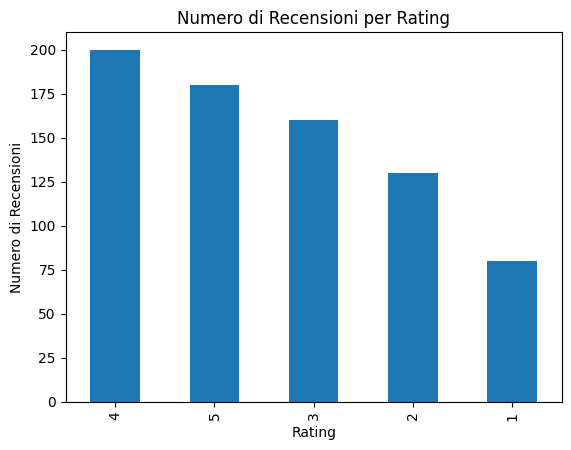

In [ ]:
# values counting
count_by_rating = df_subset['rating'].value_counts()

# bar plot
count_by_rating.plot.bar()
plt.xlabel('Rating')
plt.ylabel('Numero di Recensioni')
plt.title('Numero di Recensioni per Rating')
plt.show()


In [ ]:
df_subset.head()

In [29]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.9 MB/s eta 0:00:00


In [31]:
# downloading model and weights
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

(…)-base-sentiment/resolve/main/config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

(…)a-base-sentiment/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…)a-base-sentiment/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)ent/resolve/main/special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [32]:
example = df['review'][50]
example

'I just spent an hour and fifteen minutes at this site. I found it to be very well put together & easy to get around in. The information is presented in an easy to follow pattern from start to finish. I understood most of what I perused except the technical math notation. A person of any age would benefit from this site. It offers math, history, art & science all at one time! Students and teachers alike can find many ideas and concepts in the material to enhance their own learning objectives. I could spend hours at this site & will probably return to it again sometime. I love looking at the fractal examples & "playing" with them (via the computer mouse)!'

In [33]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0015581133, 'roberta_neu': 0.011149705, 'roberta_pos': 0.9872922}


In [34]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['I', 'just', 'spent', 'an', 'hour', 'and', 'fifteen', 'minutes', 'at', 'this']

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

In [ ]:
df.tail(1)

In [ ]:
df.shape

(300, 10)

In [ ]:
def polarity_scores_roberta(example):
    # Tokenize the input example using the 'tokenizer' with return_tensors set to 'pt' (PyTorch format)
    encoded_text = tokenizer(example, return_tensors='pt')

    # Pass the tokenized text through the 'model' and capture the output
    output = model(**encoded_text)

    # Detach and convert the tensor to a NumPy array, representing the model's scores
    scores = output[0][0].detach().numpy()

    # Apply softmax to normalize the scores
    scores = softmax(scores)

    # Create a dictionary with keys 'roberta_neg', 'roberta_neu', 'roberta_pos' and corresponding scores
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }

    # Return the scores dictionary
    return scores_dict


In [ ]:
# Initialize an empty dictionary
res = {}

# Iterate through the rows of the DataFrame df_subset using tqdm for progress tracking
for i, row in tqdm(df_subset.iterrows(), total=len(df)):
    # Use try-except block to handle potential runtime errors
    try:
        # Extract the 'text_copy' and 'id' values from the current row
        text = row['text_copy']
        myid = row['id']

        # Calculate Vader polarity scores for the text using the analyzer
        vader_result = analyzer.polarity_scores(text)

        # Rename the Vader result keys to include 'vader_' as a prefix
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}

        # Calculate RoBERTa polarity scores for the text using the polarity_scores_roberta function
        roberta_result = polarity_scores_roberta(text)

        # Combine Vader and RoBERTa results into a single dictionary
        both = {**vader_result_rename, **roberta_result}

        # Store the combined results in the res dictionary using the 'id' as the key
        res[myid] = both

    # Handle a specific type of exception (RuntimeError) and print a message
    except RuntimeError:
        print(f'Broke for id {myid}')


  2%|▏         | 171/8536 [00:31<37:21,  3.73it/s]

Broke for id 2127


  4%|▎         | 312/8536 [01:01<35:25,  3.87it/s]

Broke for id 314


  7%|▋         | 567/8536 [01:57<22:45,  5.84it/s]

Broke for id 66


  9%|▉         | 750/8536 [02:39<27:37,  4.70it/s]


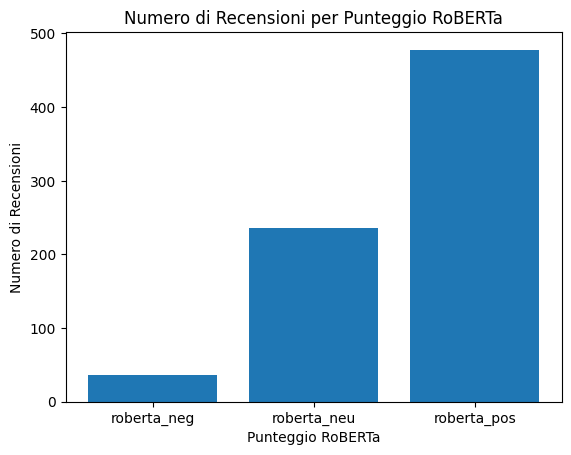

In [ ]:
# Count the number of reviews for each negative, neutral and positive RoBERTa score
count_by_roberta_neg = len(df_subset[df_subset['score'] < -0.5])
count_by_roberta_neu = len(df_subset[(df_subset['score'] >= -0.5) & (df_subset['score'] <= 0.5)])
count_by_roberta_pos = len(df_subset[df_subset['score'] > 0.5])

# bar plot
plt.bar(['roberta_neg', 'roberta_neu', 'roberta_pos'], [count_by_roberta_neg, count_by_roberta_neu, count_by_roberta_pos])
plt.xlabel('Punteggio RoBERTa')
plt.ylabel('Numero di Recensioni')
plt.title('Numero di Recensioni per Punteggio RoBERTa')
plt.show()


In [ ]:
print(df_subset.columns)

Index(['id', 'review', 'rating', 'score', 'sentiment', 'text_copy'], dtype='object')


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})

# Ensure that the 'Id' column in the DataFrame results_df is the index
results_df.set_index('Id', inplace=True)

# Ensure that the 'id' column in the DataFrame df is renamed to 'Id'.
df.rename(columns={'id': 'Id'}, inplace=True)

# Performs the merge using the 'Id' column as the key
results_df = results_df.merge(df, how='left', on='Id')


In [ ]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'review', 'rating',
       'score', 'sentiment', 'text_copy'],
      dtype='object')

In [ ]:
"""import seaborn as sns
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='score',
            palette='tab10')
plt.show()

In [ ]:
results_df.query('rating == 1') \
    .sort_values('roberta_pos', ascending=False)['review'].values[0]

In [ ]:
results_df.query('rating == 1') \
    .sort_values('vader_pos', ascending=False)['review'].values[0]

'This material was quite good when originally submitted 12 years ago, however it is severely outdated at this time. Activities reference files which are not present on the website. Activities reference software which is no longer supported.'

In [ ]:
results_df.query('rating == 5') \
    .sort_values('roberta_neg', ascending=False)['review'].values[0]

'I have visited several sights with the similar purpose of illustrating vector addition, but this one seems to really help you visualize the process.                         -J.B.'

In [ ]:
results_df.query('rating == 5') \
    .sort_values('vader_neg', ascending=False)['review'].values[0]

'THE LINK IS DEAD.'

In [ ]:
# Select reviews with rating 1 and sort by 'roberta_pos' in descending order
selected_reviews = results_df.query('rating == 1').sort_values('roberta_pos', ascending=False)

# Display the first n reviews with the highest 'roberta_pos' rating
n = 20 # Set the number of reviews to display
top_reviews = selected_reviews.head(n)['review'].values

print("The first {} reviews with a rating of 1 and the highest 'roberta_pos' score are:".format(n))
for idx, review in enumerate(top_reviews, 1):
    print(f"Recensione {idx}:")
    print(review)
    print("-" * 50)


In [ ]:
# Select reviews with rating 1 and sort by 'roberta_pos' in descending order
selected_reviews = results_df.query('rating == 1').sort_values('roberta_pos', ascending=False)

# View reviews with the highest 'roberta_pos' rating
print("Reviews with a rating of 1 and the highest 'roberta_pos' rating:")
print("-" * 50)
for idx, row in selected_reviews.iterrows():
    review_text = row['review']
    roberta_pos_score = row['roberta_pos']
    print(f"Recensione {idx} - Punteggio 'roberta_pos': {roberta_pos_score}")
    print(review_text)
    print("-" * 50)


In [ ]:
# Select reviews with rating 1 and sort by 'roberta_pos' in descending order
selected_reviews = results_df.query('rating == 1').sort_values('roberta_pos', ascending=False)

# Display the last n reviews with the lowest 'roberta_pos' rating
n = 100 # Set the number of reviews to display
lowest_reviews = selected_reviews.tail(n)['review'].values

print("Latest {} reviews with a rating of 1 and the lowest 'roberta_pos' score are:".format(n))
print("-" * 50)
for idx, review in enumerate(lowest_reviews, 1):
    print(f"Review {idx}:")
    print(review)
    print("-" * 50)


In [ ]:
#Conta il numero di recensioni per ciascun punteggio
count_pos = len(results_df[(results_df['roberta_pos'])])# > 0.5])
count_neu = len(results_df[(results_df['roberta_pos'])])# >= -0.5) & (results_df['roberta_pos'] <= 0.5)])
count_neg = len(results_df[results_df['roberta_pos'] < -0.5])

# Crea un plot a barre
plt.bar(['roberta_pos', 'roberta_neu', 'roberta_neg'])#, [count_pos, count_neu, count_neg])
plt.xlabel('Score RoBERTa')
plt.ylabel('Number of reviews')
plt.title('Number of reviews for score RoBERTa')
plt.show()
